# **NLP with Transformers + LoRA vs. RNNs and DICTIONARIES**


We are provided with 2000 tweets about Bitcoin and a corresponding sentiment score (1 if positive and 0 if negative). The task is to perform sentiment analysis using a sentiment dictionary, an RNN model, a pre-trained Transformer, and a fine-tuned Transformer. The data is separated into a train set of 1500 tweets and a test set of 500 tweets – both of which are labeled.

Workflow:

- We apply 2 baseline classifiers:
  - A lexicon is applied to provide a benchmark
  -  A Bidirectional-GRU-Network is trained on our training data
- And 3 different pre-trained BERT-based transformer models, which we fine-tune for our specific task:
  -  DistilBERT
  -  BERT
  -  And RoBERTa

Each section gives a short theoretical summary of the classifier, the preprocessing steps, the training and application of the classifier, as well as it's performance on the test data.
Lastly, a brief discussion on the results is held.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Project Directory
import os
os.chdir('/content/drive/MyDrive/Colab_Notebooks/assignments')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# SETUP

* **pandas**: A data manipulation and analysis library for handling and analyzing structured data.
* **numpy**: A package for scientific computing, providing support for large arrays and matrices.
* **collections**: Provides alternatives to Python’s general-purpose built-in containers, such as Counter.
* **re**: The regular expression library for pattern matching in strings.
* **unicodedata**: Provides access to the Unicode Character Database.
* **nltk**: The Natural Language Toolkit, a comprehensive library for text processing and linguistic data analysis.
* **emoji**: For handling emojis in text, enabling their manipulation and analysis.
* **torch**: A deep learning library that provides tools for building and training neural networks.
* **transformers**: A library by Hugging Face for working with state-of-the-art Transformer models in NLP tasks.
* **peft:** peft offers parameter-efficient methods for finetuning large pretrained models. It trains a smaller number of prompt parameters or use a reparametrization method like low-rank adaptation (LoRA) to reduce the number of trainable parameters.
peft: A library for Parameter-Efficient Fine-Tuning, used for adapting large language models with fewer parameters.
* **sklearn**: a machine learning library that provides simple and efficient tools for data analysis and modeling.
* **matplotlib**: for creating visualizations.
* **seaborn**: builds on Matplotlib to provide a high-level interface for statistical graphics.
* **random**: For generating pseudo-random numbers for various probabilistic tasks.



In [ ]:
!pip install emoji
!pip install peft
!pip install watermark

%load_ext watermark

# Import necessary modules
import pandas as pd
import numpy as np
from collections import Counter
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
import emoji
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import (DistilBertTokenizer, DistilBertForSequenceClassification, Trainer,
                          TrainingArguments, pipeline, AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding)
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix,
                             roc_auc_score, roc_curve, precision_recall_curve, average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Set random seeds for reproducibility
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Setting the device to GPU if available for pytorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Save requirements
!pip3 freeze > requirements.txt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
%watermark -v -m -p pandas,numpy,scipy,seaborn,sklearn,matplotlib,nltk,re,bs4,emoji,torch,transformers,peft

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

pandas      : 2.1.4
numpy       : 1.26.4
scipy       : 1.13.1
seaborn     : 0.13.1
sklearn     : 1.3.2
matplotlib  : 3.7.1
nltk        : 3.8.1
re          : 2.2.1
bs4         : 4.12.3
emoji       : 2.12.1
torch       : 2.4.0+cu121
transformers: 4.42.4
peft        : 0.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.85+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



# Helper Functions


In NLP, sometimes even more crucial than the algorithm can be the choice of text preprocessing.

**PREPROCESSING:**

For this purpose we define one textpreprocessor for the Dictionary and the RNN input. Here we perform standard text cleaning like removing URL's, user mentions, whitespaces, Unicode, and empty tokens. Further, a demojization is performed to translate emojis into text representations. To reduce the dimensionality of the inputs we apply stemming and lowercasing. Additionally  stop words and punctuation are removed.

Transformer models are generally more flexible and can capture more complex semantic relations, as they have more parameters and training data, which is usually not preprocessed. Therefore a second mode for the function is created, to only remove URLS's, user mentions, and empty tokens.

**EVALUATION METRICS**

Further, we define a function to evaluate the classification tasks. Intuitive metrics like Accuracy can become biased towards the majority class in the presence of class imbalance, which we will see for in our data. Therefore **we primarily look at the ROC_AUC and PR_AUC by class.**
PR_AUC and ROC_AUC have the benefit of threshold independence because they use probabilities as input. As the Distilbert API and the Vader Lexicon have no way of learning the class distribution, they potentially have different ideal thresholds than the trained or fintuned model.
For that reason, the **confusion matrix and F1 metrics have to be interpreted with caution and are not considered for evaluation.**

- ROC Curve: The ROC curve is a plot of the true positive rate (TPR or recall) against the false positive rate (FPR) at various threshold settings.
    - TPR or Recall, is the ratio of correctly predicted positive observations to all actual positives.
    - FPR, is the ratio of incorrectly predicted positive observations to all actual negatives.

As the ROC_AUC only takes the ratio of the positive class into account it behaves symmetrically with respect to the negative class in a binary setting, thus it behaves indifferently to class imbalance.

Nevertheless, it is not able to give distinct metrics by class. Therefore we also consider the pr_auc score.

- The PR curve plots precision against recall at various threshold settings.
  - Precision: The ratio of total True Positives by the sum of total True Positives and False Positives
  - Recall (TPR): The ratio of correctly predicted positive observations to all actual positives.


Both scores are calculated by integrating the area under the curve.
- AUC Score:
  - 1 indicates a perfect classifier.
  - 0.5: Classifier with no discrimination ability (random guessing).
  - 0: Classifier that always misclassifies.



Lastly, some functions for convenient Indexing, Padding and Vader-dictionary-application are defined.


In [ ]:
# Text Preprocessing Function
class TextPreprocessor:
    def __init__(self, mode='default'):
        """
        Initialize the TextPreprocessor with a specific mode.
        Modes can be 'default' for the full pipeline or 'dbert' for the simplified pipeline.
        """
        self.mode = mode

    def preprocess(self, tokens):
        """Apply the selected preprocessing steps to a list of tokens."""
        if self.mode == 'default':
            return self._preprocess_default(tokens)
        elif self.mode == 'dbert':
            return self._preprocess_dbert(tokens)
        else:
            raise ValueError("Invalid mode selected. Choose 'default' or 'dbert'.")

    def _preprocess_default(self, tokens):
        """Apply the full preprocessing pipeline."""
        tokens = self.remove_whitespace(tokens)
        tokens = self.remove_user_mentions(tokens)
        tokens = self.remove_urls(tokens)
        tokens = self.remove_unicode(tokens)
        tokens = [emoji.demojize(token) for token in tokens]
        tokens = self.remove_punctuation_and_casing(tokens)
        tokens = self.remove_stopwords(tokens)
        tokens = self.lemmatize_words(tokens)
        tokens = self.remove_empty_tokens(tokens)
        return tokens

    def _preprocess_dbert(self, tokens):
        """Apply the simplified preprocessing pipeline for dbert."""
        tokens = self.remove_user_mentions(tokens)
        tokens = self.remove_urls(tokens)
        tokens = self.remove_empty_tokens(tokens)
        return tokens

    def remove_whitespace(self, tokens):
        """Remove extra whitespaces, tabs, and newlines from each token."""
        return [re.sub(r'\s+', ' ', token).strip() for token in tokens]

    def remove_user_mentions(self, tokens):
        """Remove tokens that start with '@'."""
        return [token for token in tokens if not token.startswith('@')]

    def remove_urls(self, tokens):
        """Remove URLs from each token."""
        return [re.sub(r'http\S+|www\S+|https\S+', '', token, flags=re.MULTILINE) for token in tokens]

    def remove_unicode(self, tokens):
        """Remove unicode characters from each token."""
        return [token.encode('ascii', 'ignore').decode('ascii') for token in tokens]

    def remove_punctuation_and_casing(self, tokens):
        """Remove punctuation and convert to lowercase for each token."""
        return [re.sub(r'[^\w\s]', '', token).lower() for token in tokens]

    def remove_stopwords(self, tokens):
        """Remove stopwords from each token."""
        return [token for token in tokens if token not in english_stopwords]

    def lemmatize_words(self, tokens):
        """Lemmatize each token."""
        return [lemmatizer.lemmatize(token) for token in tokens]

    def remove_empty_tokens(self, tokens):
        """Remove empty tokens."""
        return [token for token in tokens if token]

# Classification Report
def assess_sentiment_classifier(ytest, yhat, plot_roc=True, plot_pr=True):
    ''' Function to assess a classification model in terms of the AUC,
    PR AUC, and classification accuracy. Also prints the plots of the
    ROC_AUC and PR_AUC curves if specified '''

    # # Calculate classification ROC AUC, and PR AUC
    roc_auc = roc_auc_score(ytest, yhat)
    pr_auc_pos = average_precision_score(ytest, yhat)
    pr_auc_neg = average_precision_score(1 - ytest, 1 - yhat)

    if plot_roc and plot_pr:
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        # ROC Curve
        fpr, tpr, _ = roc_curve(ytest, yhat)
        ax[0].plot(fpr, tpr, label="ROC AUC={:.4}".format(roc_auc))
        ax[0].plot([0, 1], [0, 1], "r--")
        ax[0].set_ylabel('True positive rate')
        ax[0].set_xlabel('False positive rate')
        ax[0].legend(loc='lower right')
        ax[0].set_title('ROC Curve')

        # Precision-Recall Curves
        precision_pos, recall_pos, _ = precision_recall_curve(ytest, yhat)
        precision_neg, recall_neg, _ = precision_recall_curve(1 - ytest, 1 - yhat)
        ax[1].plot(recall_pos, precision_pos, label="PR AUC (Positive Class)={:.4}".format(pr_auc_pos), color='blue')
        ax[1].plot(recall_neg, precision_neg, label="PR AUC (Negative Class)={:.4}".format(pr_auc_neg), color='green')
        ax[1].set_ylabel('Precision')
        ax[1].set_xlabel('Recall')
        ax[1].legend(loc='lower left')
        ax[1].set_title('Precision-Recall Curve')

        plt.show()

# VADER Sentiment Analyzer
def get_vader_sentiment_score(tokens):
    """Get sentiment score from the list of tokens using VADER dictionary."""
    text = ' '.join(tokens)
    sentiment = analyzer.polarity_scores(text)
    return sentiment

# Indexing and pad sequencing
def indexing(text, vocab):
    return [vocab[word] for word in text if word in vocab]

def pad_sequence(seq, max_len):
    return seq[:max_len] + [0] * (max_len - len(seq))

## Loading the data

Here we can observe that our data has 1500 labeled tweets for training and 500 for testing. There is information on the username and the used hashtags which we disregard. Most notably we see a large class imbalance with there being only 18 % negative labels. This can potentially lead to biased estimates where the model learns to focus only on the positve class. For the latter RNN-training and Distilbert-Finetuning we introduce a validation split, consisting of 20% of the training data.

In [ ]:
tweets_train = pd.read_parquet('btc_tweets_train.parquet.gzip')
tweets_test = pd.read_parquet('btc_tweets_test.parquet.gzip')


# Binary-encode the target variable
tweets_train['sentiment'] = tweets_train['sentiment'].map({True: 1 , False : 0})
tweets_test['sentiment'] = tweets_test['sentiment'].map({True: 1 , False : 0})


# Tokenize the tweets (tweet_tokenizer is the obvious choice)
tweets_train['content_tokenized'] = tweets_train['content'].apply(lambda x: TweetTokenizer().tokenize(x))
tweets_test['content_tokenized'] = tweets_test['content'].apply(lambda x: TweetTokenizer().tokenize(x))


tweets_train.head()

,hashtags,content,username,user_displayname,sentiment,content_tokenized
tweet ID,,,,,,
1641579121972236290,"[Bitcoin, Bitcoin, BTC, Bitcoin, BTC, SHIB, HO...","$Bitcoin TO $100,000 SOONER THAN YOU THINK‼️💯🙏...",BezosCrypto,SHIB Bezos,1,"[$, Bitcoin, TO, $, 100,000, SOONER, THAN, YOU..."
1641579176171016194,"[Bitcoin, bitcoinordinals, crypto]",Alright I have my rares. Who else is grabbing ...,spartantc81,SpartanTC,1,"[Alright, I, have, my, rares, ., Who, else, is..."
1641579486071390208,"[BTC, SHIB, HOGE, SAITAMA, BNB, DOGE, ETH, Bab...","Bitcoin (BTC) Targets Over $100,000 as This Im...",BezosCrypto,SHIB Bezos,1,"[Bitcoin, (, BTC, ), Targets, Over, $, 100,000..."
1641579537103302656,[BTC],📢 Xverse Web-based pool is live:\n\n•Update @x...,godfred_xcuz,Algorithm.btc,1,"[📢, Xverse, Web-based, pool, is, live, :, •, U..."
1641579588399804418,[Bitcoin],"Yesterday, a Bitcoin projection was displayed ...",goddess81oo,she is lucky,1,"[Yesterday, ,, a, Bitcoin, projection, was, di..."


In [ ]:
# Define features and target
X_train = tweets_train['content_tokenized']
y_train = tweets_train['sentiment']

X_test = tweets_test['content_tokenized'].to_numpy()
y_test = tweets_test['sentiment'].to_numpy()

print('Data Shapes:\n', X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Data Shapes:
 (1500,) (1500,) (500,) (500,)


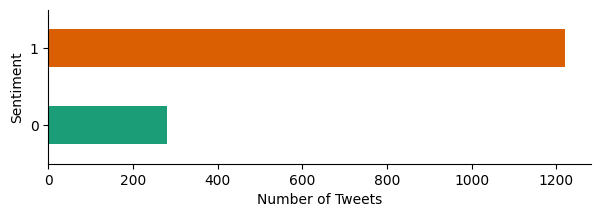


Total count: sentiment
0     280
1    1220
dtype: int64


In [ ]:
sentiment_counts = tweets_train.groupby('sentiment').size()
plt.figure(figsize=(7, 2))

# Plot the sentiment distribution
sentiment_counts.plot(kind='barh', color=sns.color_palette('Dark2'))

plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Number of Tweets')
plt.ylabel('Sentiment')
plt.show()


print('\nTotal count:', sentiment_counts)

In [ ]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = np.array(X_train), np.array(X_val), np.array(y_train), np.array(y_val)

## Dictionary

In [ ]:
# DICTIONARY PIPELINE
english_stopwords = stopwords.words('english') # dependency for TextPreprocessor
lemmatizer = WordNetLemmatizer() # dependency for TextPreprocessor

preprocessor = TextPreprocessor(mode='default')
# Preprocess training and validation sets
X_train_dict = [preprocessor.preprocess(token) for token in X_train]
X_test_dict = [preprocessor.preprocess(token) for token in X_test]

### Information on the (default-) preprocessed Training Data

After preprocessing the tweets with the default mode for Dictionaries and RNNs the longest tweet size has almost halved from 80 to 43. Looking at the most used words we see that bitcoin and crypto are leading the ladder.

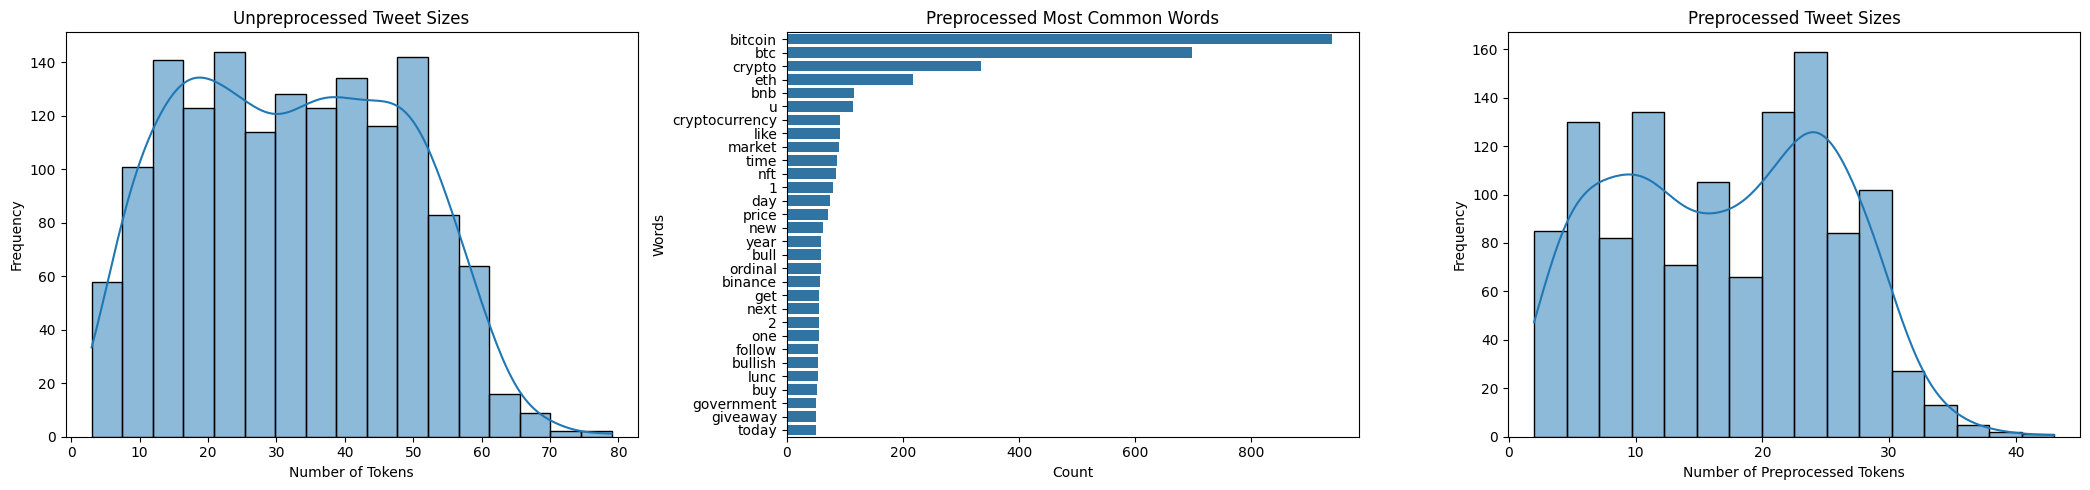

In [ ]:
# Calculate the size (number of tokens) for each tweet
tweet_sizes_unprocessed = [len(tweet) for tweet in tweets_train['content_tokenized']]

# Calculate tweet sizes (number of tokens per document)
tweet_sizes_processed = [len(document) for document in X_train_dict]

# Combine all tokens from the preprocessed text into a single list for frequency analysis
all_tokens_processed = [token for document in X_train_dict for token in document]

# Count the frequency of each token in the preprocessed text
counter_processed = Counter(all_tokens_processed)
most_common_words_processed = counter_processed.most_common(30)
words_processed, counts_processed = zip(*most_common_words_processed)

# Create the plots
fig, axes = plt.subplots(1, 3, figsize=(21, 5))  # 1 row, 3 columns

# Plot for unprocessed tweet sizes
sns.histplot(tweet_sizes_unprocessed, kde=True, ax=axes[0])
axes[0].set_title('Unpreprocessed Tweet Sizes')
axes[0].set_xlabel('Number of Tokens')
axes[0].set_ylabel('Frequency')

# Plot for most common words in preprocessed text
sns.barplot(x=counts_processed, y=words_processed, ax=axes[1])
axes[1].set_title('Preprocessed Most Common Words')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Words')

# Plot for preprocessed tweet sizes
sns.histplot(tweet_sizes_processed, kde=True, ax=axes[2])
axes[2].set_xlabel('Number of Preprocessed Tokens')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Preprocessed Tweet Sizes')

plt.tight_layout()
plt.show()

# Applying the VADER Dictionary on the Test Set as a Baseline

### THEORY

VADER (Valence Aware Dictionary and sEntiment Reasoner):

- VADER is a lexicon specifically designed to analyze social media texts, particularly adept at capturing the sentiment expressed in tweets, reviews, and comments, where language can be informal and filled with abbreviations, emoticons, and slang.

- VADER's strength lies in ease of use and its ability to handle the nuances of social media language while maintaining a high level of accuracy. It combines a sentiment dictionary with grammatical and syntactical rules that help quantify sentiment more effectively than standard lexicon-based methods.
At its core is a sentiment lexicon, a predefined list of words and their associated sentiment scores. The scores range from -4 to +4, where:
  - Words with positive sentiment have scores closer to +4 (e.g., "happy", "excellent").
  - Words with negative sentiment have scores closer to -4 (e.g., "sad", "terrible").
 Words that are neutral or context-dependent have scores near 0.

- In addition to the sentiment dictionary, VADER applies several grammatical and syntactical rules that adjust the sentiment score based on context. These rules account for:
  - Punctuation: Exclamation marks and question marks can amplify sentiment. For example, "good!!!" would have a stronger positive sentiment than "good".
  - Capitalization: Words in all caps are often used for emphasis in informal text. For instance, "GOOD" may be interpreted as more positive than "good".
  - Degree Modifiers (Intensifiers): Words like "very", "extremely", or "slightly" can modify the intensity of the sentiment. For example, "very good" would have a higher positive score than "good", while "barely good" would have a lower score.
  - Negations: The presence of negations (e.g., "not", "never") can flip the sentiment of the words that follow. For example, "not good" would be interpreted as negative.
  - Conjunctions: Conjunctions like "but" can indicate contrast, where the sentiment after "but" typically has more weight than the sentiment before it. For example, "The movie was good, but the ending was bad" would result in an overall negative sentiment score.

- Compound Sentiment Score
  - VADER outputs a sentiment score, which is a normalized, weighted sum of the individual word scores after applying the rules. The compound score ranges from -1 to +1, where: 1 equals a positive text and -1 a negative text.
- **To compare the score with other classifiers we scale it to have a range of [0,1].**

- Limitations and Considerations
  - VADER may struggle with more complex linguistic phenomena, such as sarcasm or irony, which can mislead the sentiment scoring. Further, VADER is limited to tokens in its lexicon and can not learn new relations. Therefore preprocessing has to be more restrictive which can lead to loss of information.
  - Most notably Vader distincts neutral classes, which have a compound score close to 0 [-1,1]. We ignore this information for the sake of comparability, which is a potential shortcoming.

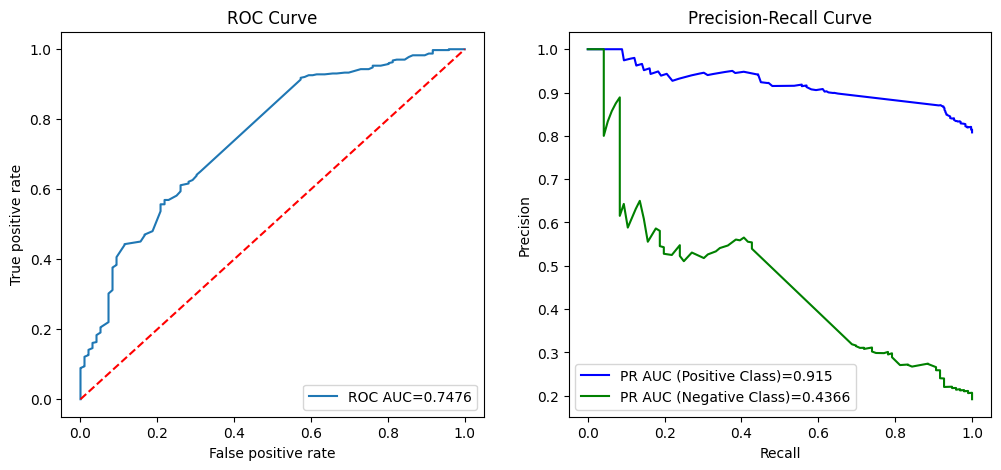

In [ ]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Get sentiment scores using VADER
prediction_dict = [get_vader_sentiment_score(tokens) for tokens in X_test_dict]

# Initialize dictionaries for storing the results
pred_test = pd.DataFrame()
pred_test['TRUE'] = y_test


# Scale the compound scores from [-1, 1] to [0, 1]
pred_test['dict'] = [(score['compound'] + 1) / 2 for score in prediction_dict]

# Store the compound score from VADER sentiment analysis
pred_test['dict'] = np.array(pred_test['dict'])

# Evaluate
assess_sentiment_classifier(y_test, pred_test['dict'])

### Dictionary Evaluation

In this classification report we can see that the Vader dictionary delivers a solid base estimation, with a high pr_auc score for the positive class and roc_auc score around 0.75. Nevertheless, it has difficulties detecting the negative class, as shown by differences in pr_auc by class. This is surprising as the lexicon has no way of 'learning' anything about the class distribution, therefore it can not be biased towards the majority calls. This hints at a unique property of the data, which can be related to the context in which negative tweets about are posted.

As earlier mentioned, we disregard any metric based on the confusion matrix because of the threshold dependence.

# Training an RNN-based language classifier in *PyTorch*

### RNN preprocessing

Coming to our first model we have to apply specific preprocessing steps:

We apply the previous Text-preprocessing pipeline to the training validation and testing set.
Next up a vocabulary dictionary is created from the preprocessed training data. All unique tokens in the training set are enumerated and assigned an index starting from 1. This dictionary maps each unique token to a unique index.

Each list of tokens in the training, validation, and test sets is then converted to a sequence of indices based on the vocabulary. The sequences are then padded to a fixed length (MAX_LEN = 43) to ensure uniform input size for the model. Padding ensures that all sequences have the same length, with shorter sequences being filled up with 0s.
Conversion to Tensors:

The indexed and padded sequences for the training, validation, and test sets are converted into PyTorch tensors (torch.tensor). Similarly, the target labels (y_train, y_val, y_test) are also converted to tensors.

The preprocessed and tensor-converted datasets (training and validation) are then wrapped into TensorDataset objects, which bundle the features and labels together. These datasets are then passed into PyTorch DataLoader objects, which allows for efficient batching during model training. BATCH_SIZE determines the number of samples per batch.

In [ ]:
MAX_LEN = 43
BATCH_SIZE = 8


preprocessor = TextPreprocessor(mode='default')

# Prepcrocess the tokens
X_train_rnn = [preprocessor.preprocess(tokens) for tokens in X_train]
X_val_rnn = [preprocessor.preprocess(tokens) for tokens in X_val]
X_test_rnn = [preprocessor.preprocess(tokens) for tokens in X_test]

# Create a dictionary
all_tokens = [word for sublist in X_train_rnn for word in sublist]
vocab = {word: idx for idx, word in enumerate(set(all_tokens), start=1)}

X_train_rnn = [pad_sequence(indexing(text, vocab), MAX_LEN) for text in X_train_rnn]
X_val_rnn = [pad_sequence(indexing(text, vocab), MAX_LEN) for text in X_val_rnn]
X_test_rnn = [pad_sequence(indexing(text, vocab), MAX_LEN) for text in X_test_rnn]

# Convert to tensors for pytorch input
X_train_rnn = torch.tensor(X_train_rnn, dtype=torch.long)
y_train_rnn = torch.tensor(y_train, dtype=torch.long)
X_val_rnn = torch.tensor(X_val_rnn, dtype=torch.long)
y_val_rnn = torch.tensor(y_val, dtype=torch.long)
X_test_rnn = torch.tensor(X_test_rnn, dtype=torch.long)
y_test_rnn = torch.tensor(y_val, dtype=torch.long)

# Create DataLoaders for batching
train_dataset = torch.utils.data.TensorDataset(X_train_rnn, y_train_rnn)
val_dataset = torch.utils.data.TensorDataset(X_val_rnn, y_val_rnn)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size= BATCH_SIZE, shuffle=False)



print('Datashapes\n:', X_train_rnn.shape, X_val_rnn.shape , X_test_rnn.shape)

Datashapes
: torch.Size([1200, 43]) torch.Size([300, 43]) torch.Size([500, 43])


### Theory: Bidirectional RNN with LSTM Layers


* Gated Recurrent Unit (GRU)
  - Unlike traditional feed-forward neural networks, which process inputs independently, Recurrent Neural Networks (RNNs) maintain a hidden state that is updated at each time step, enabling the network to capture dependencies and patterns over time. However, RNNs often struggle with vanishing or exploding gradient problems during training, which makes it challenging for them to retain information across long sequences. To address this, GRU units were designed to efficiently maintain long-term dependencies by using a simplified gating mechanism. This mechanism controls the flow of information and helps the network decide what information to keep and what to discard, making GRUs particularly effective in handling sequences of varying lengths.

* Bidirectional RNN (BiRNN)
  - BiRNN is an extension of the traditional RNN that involves two parallel RNNs. One processes the input sequence in the forward direction and the other in the backward direction. The output of these two RNNs is then combined, typically by concatenating their hidden states. This architecture enables the model to have access to both past (previous time steps) and future (subsequent time steps) context for each point in the sequence.




### RNN Model Specification

In [ ]:
class BiRNNClassifier(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, output_size, num_layers, device, dropout_prob=0.5):
        super(BiRNNClassifier, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Embedding layer
        self.embedding = nn.Embedding(input_size, embed_size)

        # Bidirectional GRU with dropout
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers, bidirectional=True, batch_first=True, dropout=dropout_prob)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size * 2, output_size)  # 2 for bidirectional

    def forward(self, x):
        # Embedding
        x = self.embedding(x)

        # Set initial hidden state for GRU
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(self.device)  # 2 for bidirectional

        # Forward propagate GRU
        h_rnn, _ = self.rnn(x, h0)  # h_rnn: tensor of shape (batch_size, seq_length, hidden_size*2)

        # Apply tanh activation to the output of the GRU
        h_rnn = torch.tanh(h_rnn)

        # Take the last hidden state (batch_size, hidden_size*2)
        h_rnn = h_rnn[:, -1, :]

        # Pass the last hidden state through the fully connected layer
        logits = self.fc(h_rnn)

        return logits

### RNN training

Epoch 1, Training Loss: 0.5173, Validation Loss: 0.4830
Epoch 2, Training Loss: 0.4846, Validation Loss: 0.4851
Epoch 3, Training Loss: 0.4834, Validation Loss: 0.4833
Epoch 4, Training Loss: 0.4846, Validation Loss: 0.4833
Epoch 5, Training Loss: 0.4808, Validation Loss: 0.4783
Epoch 6, Training Loss: 0.4221, Validation Loss: 0.4489
Epoch 7, Training Loss: 0.2862, Validation Loss: 0.4667
Epoch 8, Training Loss: 0.1764, Validation Loss: 0.5947
Epoch 9, Training Loss: 0.1366, Validation Loss: 0.6076
Epoch 10, Training Loss: 0.1047, Validation Loss: 0.6637
Epoch 11, Training Loss: 0.0922, Validation Loss: 0.6703
Epoch 12, Training Loss: 0.0686, Validation Loss: 0.8433
Epoch 13, Training Loss: 0.0516, Validation Loss: 0.7882
Early stopping triggered.


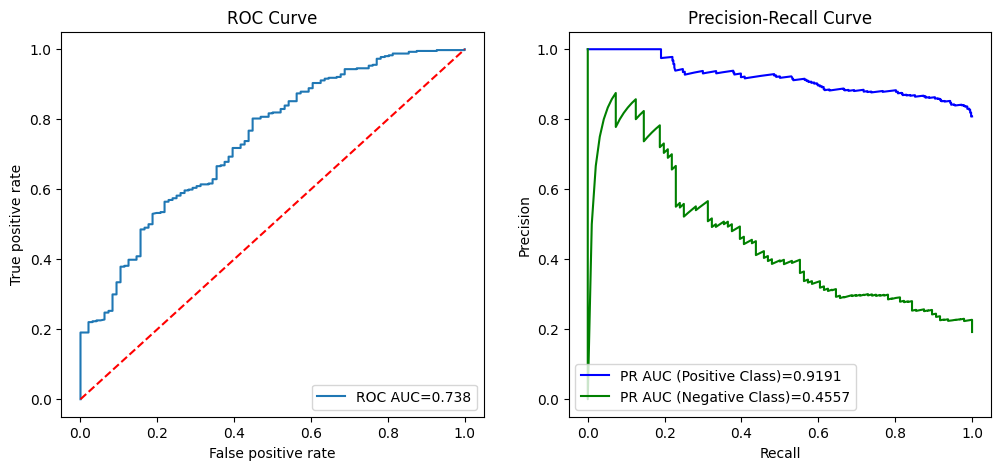

In [ ]:
# Set Hyperparameters and the maximum sequence length
LR = 0.001
EPOCHS = 100
HIDDEN_SIZE = 16
LAYERS = 3
EMBED_SIZE = 64


# Define early stopping parameters
PATIENCE = 10  # Number of epochs to wait after last improvement
patience_counter = 0 # Initialization of the patience
best_val_loss = float('inf')  # Initialize the best validation loss to infinity
best_model_state = None  # To store the best model's state


# Define the model
model = BiRNNClassifier(input_size=len(vocab) + 1, embed_size= EMBED_SIZE, output_size=1, hidden_size= HIDDEN_SIZE, num_layers= LAYERS, device=device).to(device)


# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= LR)

# Training loop with early stopping
for epoch in range(EPOCHS):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch.float())
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch.float())
            val_loss += loss.item()

    avg_training_loss = training_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f'Epoch {epoch+1}, Training Loss: {avg_training_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()  # Store the best model's state
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break  # Exit the training loop

# Load the best model's state for evaluation
model.load_state_dict(best_model_state)


model.eval()
with torch.no_grad():
    # Move the input data to the correct device
    test_outputs = model(X_test_rnn.to(device))
    # Perform sigmoid activation and move to CPU before converting to numpy
    predictions_rnn = torch.sigmoid(test_outputs).cpu().numpy()

# store predictions
pred_test['rnn'] = (predictions_rnn)

assess_sentiment_classifier(y_test, pred_test['rnn'])

### RNN evaluation

In this plot, we see that the model has been able to pick up information during the training process. Nonetheless, it did not exceed our baseline of the Vader sentiment dictionary. Further, the RNN has the same difficulties in predicting the negative class. The overall low performance could potentially be explained by the limitation through the size of available training data or by not tuning the hyperparameters.

#  Applying a pre-trained Classifier from Hugging Face



## Theory: The Transformer Architecture


1. Embedding

After tokenization, each token is mapped to a numeric vector. Initially, these vectors are random. In models like BERT and GPT-2, each vector has 768 dimensions. These embeddings encode relationships between tokens, allowing the model to process similar tokens in similar ways.

2. Positional Encoding

To account for the order of tokens, models like GPT-2 incorporate positional encoding. This is an additional embedding that represents the relative position of tokens, using a combination of sine and cosine functions.

3. Multihead Attention

The attention mechanism aims to create embeddings that reflect the in-context meaning of tokens. It starts with token embeddings, initially the sum of the input embeddings and positional encodings, normalized to have zero mean and unit variance. These embeddings are transformed into three lower-dimensional embeddings: queries, keys, and values. During training, the model learns to construct these queries, keys, and values to help achieve its objective.

4. Contextualized Embedding

The embeddings from the multiple attention heads are combined so that the final embedding for each token is a blend of embeddings from different heads. This final contextual embedding has the same dimensionality as the initial embeddings (768 in BERT or GPT-2 models).

5. Linear Feed-Forward

The contextualized embeddings are passed through a linear layer and then added to the original embeddings that entered the attention heads. This addition, known as a skip connection, helps stabilize the model during training.

6. Non-Linear Feed-Forward

After the skip connection, the embeddings are processed through a larger layer with a nonlinear activation function. This layer enhances the flexibility of the model by processing and recombining the contextualized token embeddings. It also increases the model's memory capacity by introducing a large number of parameters. In BERT models, this nonlinear layer is four times larger than the token embeddings, expanding to 3,072 dimensions with over two million parameters connecting the layers.

7. Final Linear Feed-Forward

Following the large nonlinear layer, the embeddings are scaled back down to the original embedding size through another linear layer. This prepares them for the next model block and includes a skip connection before the nonlinear layer to maintain stability. The attention block ultimately produces embeddings that are the same size as the initial embeddings but are now contextualized with information from other tokens.

8. Model Head

The last component is the model head, which generates the final output of the model. This output can be tailored for various tasks. During pre-training—when the model learns linguistic patterns from a large corpus—the model head typically performs token classification.


(Hussain et al. 2023)


## Encoder Models

The primary function of an encoder is to transform input data, such as text, into a fixed-size vector or sequence of vectors that capture the meaningful features of the input.

- https://huggingface.co/distilbert/distilbert-base-uncased-finetuned
- https://huggingface.co/google-bert/bert-base-uncased
- https://huggingface.co/FacebookAI/roberta-base

**BERT**: A transformer-based model that uses a bidirectional encoder to understand the context from both directions in a sentence. It has 109,632,772 params

**RoBERTa**: An optimized version of BERT with improved pretraining techniques, such as training on more data, using dynamic masking, and removing the Next Sentence Prediction (NSP) objective. It has 125,386,756 params.

**DistilBERT**: A smaller, faster version of BERT, created through knowledge distillation, retaining most of BERT's performance while being more efficient. It has 67,620,868 params.

- Similarities:
  - Self-Supervised Pretraining: BERT, RoBERTa, and DistilBERT are all pretrained on raw, unlabeled text data, which allows them to leverage large amounts of publicly available data without manual labeling.
  - Masked Language Modeling (MLM): All three models use the MLM objective during pretraining, where a portion of the words in a sentence is randomly masked, and the model must predict the masked words. This method helps the models learn a bidirectional understanding of language, capturing context from both directions.
- Distinctions:
  - Efficiency and Size:
    - DistilBERT: DistilBERT is designed to be smaller and faster than BERT, retaining about 97% of BERT's performance while being 40% smaller and 60% faster. This efficiency is achieved through knowledge distillation, where DistilBERT is trained to replicate the behavior of BERT with fewer layers and parameters.
  - Next Sentence Prediction (NSP):

    - BERT: BERT includes the NSP objective, where the model learns to predict whether two sentences are consecutive in the original text, helping it understand relationships between sentences.
    - RoBERTa: RoBERTa drops the NSP objective, focusing solely on MLM, and instead optimizes training by using larger datasets and longer sequences, which improves performance on downstream tasks.
    - DistilBERT: Following RoBERTa's lead, DistilBERT also omits the NSP objective, further streamlining the model for efficiency.


### Preprocessing

In [ ]:
# DICTIONARY PIPELINE
preprocessor = TextPreprocessor(mode='dbert')

# Preprocess data sets
X_train_dbert = [preprocessor.preprocess(token) for token in X_train]
X_val_dbert = [preprocessor.preprocess(token) for token in X_val]
X_test_dbert = [preprocessor.preprocess(token) for token in X_test]

# Unnest the data
X_train_dbert = [' '.join(sentences) for sentences in X_train_dbert]
X_val_dbert = [' '.join(sentences) for sentences in X_val_dbert]
X_test_dbert = [' '.join(sentences) for sentences in X_test_dbert]

### Prediction

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


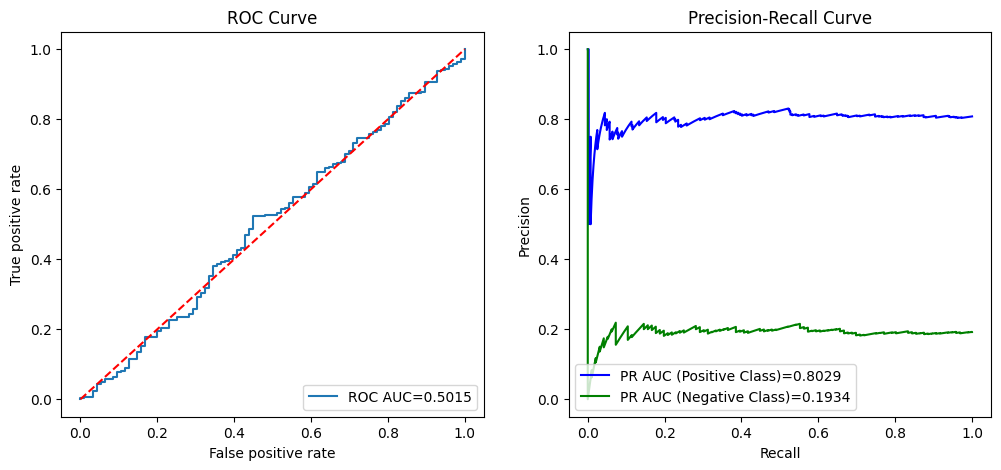

In [ ]:
# HUGINGFACE API PIPELINE
classifier = pipeline('sentiment-analysis',
                      model='distilbert-base-uncased',
                      tokenizer='distilbert-base-uncased',
                      batch_size=64,
                      device=device)


def pipeline_classify(data):
    '''Optimized function to run sentiment analysis pipeline on a dataset and extract scores.'''
    results = classifier(data, truncation=True)
    predictions = [result['score'] if result['label'] == 'POSITIVE' else 1 - result['score'] for result in results]
    return predictions

# Get predictions
predictions_dbert = pipeline_classify(X_test_dbert)

# store predicitons
pred_test['dbert'] = (predictions_dbert)

# Evaluate
assess_sentiment_classifier(y_test, pred_test['dbert'])

### Evaluation

Interestingly, this large transformer model does not perform better than a random guess. The model's encoder is pre-trained and captures general language features, but the classification layers are randomly initialized and untrained. As shown in this warning:
```
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
```

As a result, any predictions made by the model at this stage are essentially random and not reflective of the actual performance. Therefore evaluating further classifiers does not make sense. Instead, we start fine-tuning the models.

## Fine-tuning DISTILBERT with LoRA



### Preprocessing

The tokenized inputs and corresponding labels are wrapped in a custom SentimentDataset class, which inherits from PyTorch's Dataset. This class prepares the data to be fed into the model during training and evaluation, handling how each sample is accessed and returned.

In [ ]:
# Define the Tokenizer:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

X_train_ft_dbert = tokenizer(X_train_dbert, truncation=True, padding='max_length', return_tensors='pt') # pt indicates pytorch tensors
X_val_ft_dbert = tokenizer(X_val_dbert, truncation=True, padding='max_length', return_tensors='pt')
X_test_ft_dbert = tokenizer(X_test_dbert, truncation=True, padding='max_length', return_tensors='pt')

# Load the pre-trained model and define training arguments
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(X_train_ft_dbert, torch.tensor(y_train))
val_dataset = SentimentDataset(X_val_ft_dbert, torch.tensor(y_val))
test_dataset = SentimentDataset(X_test_ft_dbert, torch.tensor(y_test))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### LoRA fine-tuning

Fine-tuning large pre-trained models is computationally challenging, often involving the adjustment of millions of parameters. The traditional fine-tuning approach, while effective, demands substantial computational resources and time, posing a bottleneck for adapting these models to specific tasks.

LoRA presents an effective solution to this problem by decomposing the update matrix during finetuing. It focuses on modifying a smaller subset of parameters (lower-rank matrices). This significantly reduces the trainable parameters of the model and reduces the GPU memory requirement for the training process, which is another significant challenge when it comes to fine-tuning or training large models.

LoRA is built on the understanding that large models inherently possess a low-dimensional structure. By leveraging low-rank matrices, LoRA adapts these models effectively. Instead of changing the pre-trained parameters of a model, we only add and train lower-rank matrices, which happens relatively very quickly because of fewer parameters.

In principle, LoRA can be applied to any subset of weight matrices in a neural network. However, for simplicity and further parameter efficiency, in Transformer models LoRA is typically applied to attention blocks only. Usually only to the query and value matrices.

This also bears the benefit of not losing information from the pre-training, by recalibrating weights. Instead, we introduce new efficient task-specific weights.

In [ ]:
peft_config = LoraConfig(task_type="SEQ_CLS", # Specifies that the task type is sequence classification
                        r=4, # This sets the rank of the LoRA adaptation matrices
                        lora_alpha=32, # A scaling factor that determines the influence of the LoRA-modified layers in the model, before they are added to the model output
                        lora_dropout=0.01, # The dropout rate applied to the LoRA layers during training
                        target_modules = ["q_lin", "v_lin"]) # Specifies which layers of the model will be modified by LoRA:  q_lin = query projection layer, v_lin = value projection layer

model = get_peft_model(model, peft_config)

model.print_trainable_parameters() # less than 1% of the model's total parameters will be trainable, thanks to the additional parameters introduced by LoRA in the query and value projection layer.

trainable params: 665,858 || all params: 67,620,868 || trainable%: 0.9847


Epoch,Training Loss,Validation Loss
1,No log,0.375272
2,No log,0.315298
3,No log,0.445563


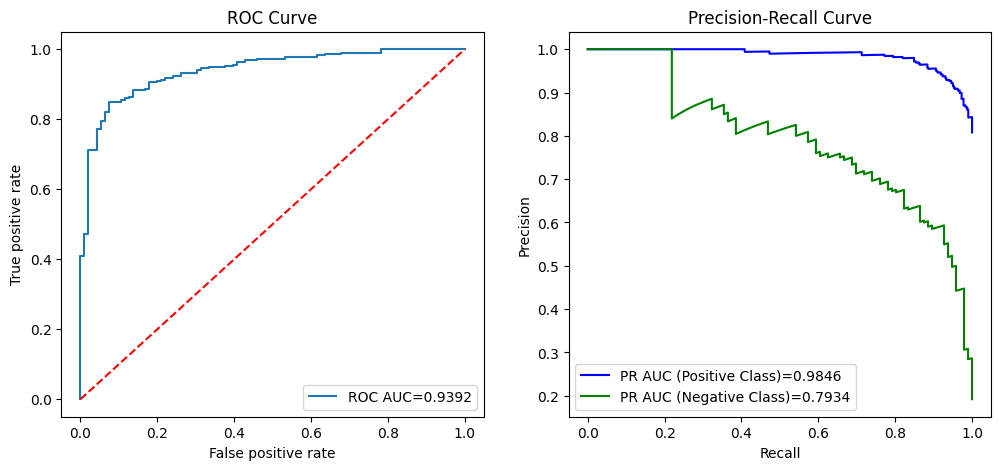

In [ ]:
# hyperparameters (fixed for all three models)
LR = 0.001
BATCH_SIZE = 8
EPOCHS = 3

torch.cuda.empty_cache() # Clears the Cuda device before training to avoid memory issues

training_args = TrainingArguments(
    output_dir = './results', # Specifies the directory where the model checkpoints and other results will be saved
    learning_rate=LR,
    per_device_train_batch_size= BATCH_SIZE,
    per_device_eval_batch_size= BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay= 0.0001, # Specifies the weight decay (regularization term) to prevent overfitting
    eval_strategy="epoch", # Specifies that evaluation will be performed at the end of each epoch
    save_strategy="epoch", # Specifies that the model will be saved at the end of each epoch
    load_best_model_at_end=True, # will load the best model (based on the evaluation metrics) observed during training
    seed = SEED,
    data_seed = SEED
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset
)

trainer.train()


### Distilbert+LoRa prediciton
predictions_dbert_ft = trainer.predict(test_dataset)

# Apply sigmoid to the predictions to get probabilities in the range [0, 1]
pred_test['dbert_ft'] = torch.nn.functional.sigmoid(torch.tensor(predictions_dbert_ft.predictions)).numpy()[:, 1]

assess_sentiment_classifier(y_test, pred_test['dbert_ft'])

# Finetuning BERT with LoRA

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 148,994 || all params: 109,632,772 || trainable%: 0.1359


Epoch,Training Loss,Validation Loss
1,No log,0.451989
2,No log,0.297994
3,No log,0.505839


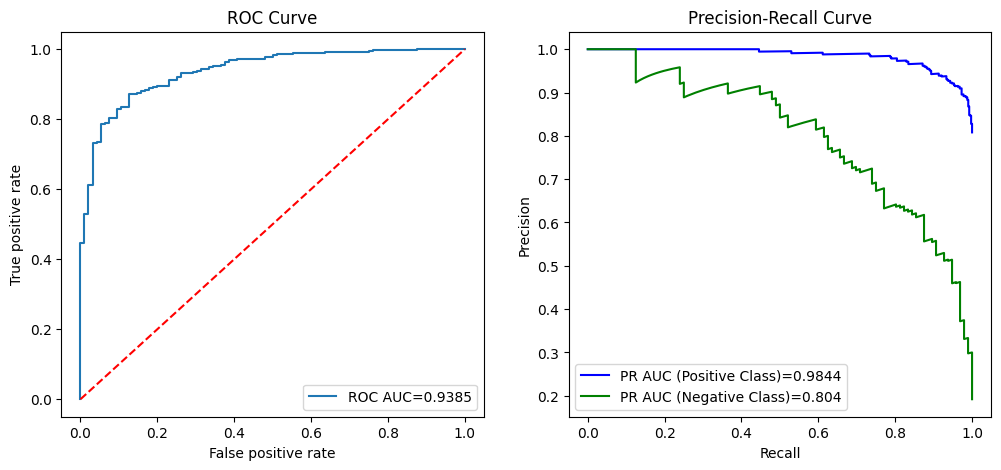

In [ ]:
# Define the Tokenizer:
tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')

X_train_ft_dbert = tokenizer(X_train_dbert, truncation=True, padding='max_length', return_tensors='pt')
X_val_ft_dbert = tokenizer(X_val_dbert, truncation=True, padding='max_length', return_tensors='pt')
X_test_ft_dbert = tokenizer(X_test_dbert, truncation=True, padding='max_length', return_tensors='pt')

# Load the pre-trained model and define training arguments
model = AutoModelForSequenceClassification.from_pretrained('google-bert/bert-base-uncased', num_labels=2)


peft_config = LoraConfig(task_type="SEQ_CLS", # Specifies that the task type is sequence classification
                        r=4, # This sets the rank of the LoRA adaptation matrices
                        lora_alpha=32, # A scaling factor that determines the influence of the LoRA-modified layers in the model, before they are added to the model output
                        lora_dropout=0.01, # The dropout rate applied to the LoRA layers during training
                        target_modules = ['query', 'value']) # Specifies which layers of the model will be modified by LoRA:  query and value projection layer

model = get_peft_model(model, peft_config)

model.print_trainable_parameters() # less than 1% of the model's total parameters will be trainable, thanks to the additional parameters introduced by LoRA in the query and value projection layer.


torch.cuda.empty_cache() # Clears the Cuda device before training to avoid memory issues

training_args = TrainingArguments(
    output_dir = './results', # Specifies the directory where the model checkpoints and other results will be saved
    learning_rate=LR,
    per_device_train_batch_size= BATCH_SIZE,
    per_device_eval_batch_size= BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay= 0.0001, # Specifies the weight decay (regularization term) to prevent overfitting
    eval_strategy="epoch", # Specifies that evaluation will be performed at the end of each epoch
    save_strategy="epoch", # Specifies that the model will be saved at the end of each epoch
    load_best_model_at_end=True, # will load the best model (based on the evaluation metrics) observed during training
    seed = SEED,
    data_seed = SEED
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset
)

trainer.train()


### Bert+LoRa prediciton
predictions_bert_ft = trainer.predict(test_dataset)

# Apply sigmoid to the predictions to get probabilities in the range [0, 1]
pred_test['bert_ft'] = torch.nn.functional.sigmoid(torch.tensor(predictions_bert_ft.predictions)).numpy()[:, 1]

assess_sentiment_classifier(y_test, pred_test['bert_ft'])

## Fine-tuning RoBERTa with LoRA

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 739,586 || all params: 125,386,756 || trainable%: 0.5898


Epoch,Training Loss,Validation Loss
1,No log,0.321742
2,No log,0.273642
3,No log,0.520846


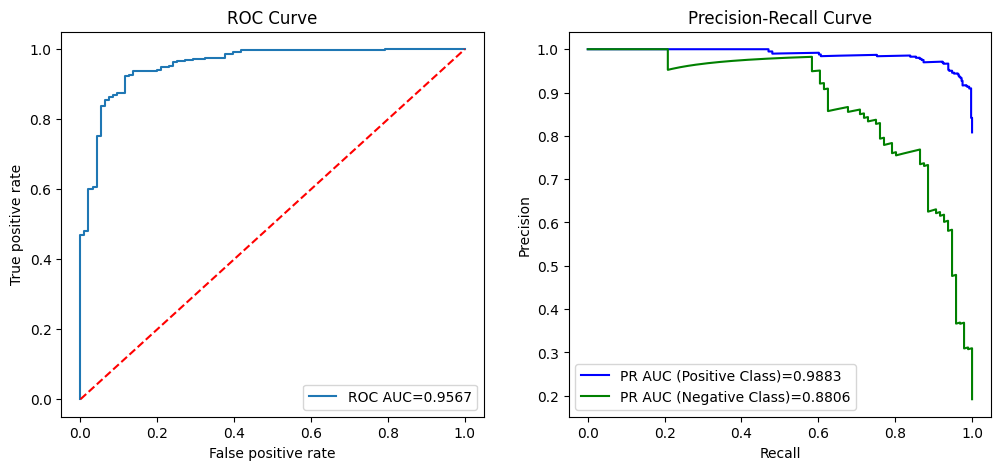

In [ ]:
# Define the Tokenizer:
tokenizer = AutoTokenizer.from_pretrained('FacebookAI/roberta-base')

X_train_ft_dbert = tokenizer(X_train_dbert, truncation=True, padding='max_length', return_tensors='pt')
X_val_ft_dbert = tokenizer(X_val_dbert, truncation=True, padding='max_length', return_tensors='pt')
X_test_ft_dbert = tokenizer(X_test_dbert, truncation=True, padding='max_length', return_tensors='pt')

# Load the pre-trained model and define training arguments
model = AutoModelForSequenceClassification.from_pretrained('FacebookAI/roberta-base', num_labels=2)

peft_config = LoraConfig(task_type="SEQ_CLS", # Specifies that the task type is sequence classification
                        r=4, # This sets the rank of the LoRA adaptation matrices
                        lora_alpha=32, # A scaling factor that determines the influence of the LoRA-modified layers in the model, before they are added to the model output
                        lora_dropout=0.01, # The dropout rate applied to the LoRA layers during training
                        target_modules = ['query', 'value']) # Specifies which layers of the model will be modified by LoRA:  query and value projection layer

model = get_peft_model(model, peft_config)

model.print_trainable_parameters() # less than 1% of the model's total parameters will be trainable, thanks to the additional parameters introduced by LoRA in the query and value projection layer.


class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(X_train_ft_dbert, torch.tensor(y_train))
val_dataset = SentimentDataset(X_val_ft_dbert, torch.tensor(y_val))
test_dataset = SentimentDataset(X_test_ft_dbert, torch.tensor(y_test))


torch.cuda.empty_cache() # Clears the Cuda device before training to avoid memory issues

training_args = TrainingArguments(
    output_dir = './results', # Specifies the directory where the model checkpoints and other results will be saved
    learning_rate=LR,
    per_device_train_batch_size= BATCH_SIZE,
    per_device_eval_batch_size= BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay= 0.0001, # Specifies the weight decay (regularization term) to prevent overfitting
    eval_strategy="epoch", # Specifies that evaluation will be performed at the end of each epoch
    save_strategy="epoch", # Specifies that the model will be saved at the end of each epoch
    load_best_model_at_end=True, # will load the best model (based on the evaluation metrics) observed during training
    seed = SEED,
    data_seed = SEED
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset
)

trainer.train()


### Distilbert+LoRa prediciton
predictions_roberta_ft = trainer.predict(test_dataset)

# Apply sigmoid to the predictions to get probabilities in the range [0, 1]
pred_test['roberta_ft'] = torch.nn.functional.sigmoid(torch.tensor(predictions_roberta_ft.predictions)).numpy()[:, 1]

assess_sentiment_classifier(y_test, pred_test['roberta_ft'])

## Interpretation of the results


In [ ]:
# Assuming your DataFrame is named pred_test
metrics = {}

# Calculating ROC AUC and PR AUC by class score for each probability column
for col in ['dict', 'rnn', 'dbert', 'dbert_ft', 'bert_ft', 'roberta_ft']:
    # ROC AUC
    roc_auc = roc_auc_score(pred_test['TRUE'], pred_test[col])

    # PR AUC for positive class
    pr_auc_pos = average_precision_score(pred_test['TRUE'], pred_test[col])

    # PR AUC for negative class
    pr_auc_neg = average_precision_score(1 - pred_test['TRUE'], 1 - pred_test[col])

    metrics[col] = {
        'ROC AUC': roc_auc,
        'PR AUC (Positive Class)': pr_auc_pos,
        'PR AUC (Negative Class)': pr_auc_neg,
    }

# Convert the metrics dictionary to a DataFrame for better visualization
metrics_df = pd.DataFrame(metrics)

print(metrics_df)

                             dict       rnn     dbert  dbert_ft   bert_ft  \
ROC AUC                  0.747589  0.737985  0.501521  0.939228  0.938531   
PR AUC (Positive Class)  0.915039  0.919139  0.802909  0.984614  0.984374   
PR AUC (Negative Class)  0.436631  0.455727  0.193441  0.793367  0.804022   

                         roberta_ft  
ROC AUC                    0.956735  
PR AUC (Positive Class)    0.988316  
PR AUC (Negative Class)    0.880553  


### Discussion

Finally, we see significant improvements, with a big increase in roc_auc and pr_auc by class, for the fine-tuned models. DistilBERT and BERT achieve similair performances (ROC_AUC ~ 0.94), which could be related to used hyperparameters. BERT would be expected to perform better then its smaller, more efficient version. RoBERTa, with around 25% more parameters then BERT, performs best (ROC_AUC ~ 0.96). It achieves near-perfect scores for the positive class (~0.99) and doubles the baseline score of the dictionary and the RNN, with 0.88. The model is still not as good in the negative class as in the positive class. Nevertheless, it has significantly increased its performance. This hints at the effectiveness of LoRA for finetuning pre-trained LLM models

To sum it up, we have been able to finetune a very capable LLM for our task through LoRA. The increase was, not only but mostly, achieved for the negative (minority) class. Rather surprisingly the RNN has not been able to surpass the VADER-lexicon, which might mean that Vader is a very good fit for this task and data, or that the RNN has not seen enough training data or hyperparameter-tuning.

The across-model dropoff in performance for the negative class hints at a property unique to the data. This could be related to the context in which users tweet about Bitcoin.

Tweets often focus on Bitcoin's price fluctuations, with users discussing significant increases or drops in value. Due to Twitter's character limit (currently 280 characters), users are encouraged to craft concise messages. This brevity often leads to the exaggeration of information, where dramatic price movements are highlighted, sometimes without nuanced context.

Further, there is a market for investment strategies, trading tips, or even scams. Some users may advertise dubious investment opportunities, promising guaranteed returns or exclusive access to profitable trades.

Moreover, automated accounts, or "bots," can amplify misleading or exaggerated information about Bitcoin, creating artificial trends and misleading users into thinking a particular investment is popular or profitable. These bots can flood Twitter with posts that push specific narratives, such as promoting a particular cryptocurrency or spreading fear about market downturns.

This might lead to dual semantics in how negative tweets about Bitcoin are represented, e.g. by highlighting negative trends and praising a 'profitable' solution'. Another consequence could be a decreased quality of the underlying training data, which does not generalize well to regular users.

Future work could improve the performance by applying the large versions of the models (e.g. bert-large.uncased), which have more available parameters, or by apply tuning the hyperparameters, like batch-size and learning rate.


### Used ressources and further readings:


- Hussain, Z. et al. (2023) ‘A tutorial on open-source large language models for behavioral science’. OSF. Available at: https://doi.org/10.31234/osf.io/f7stn.

- Devlin, J. et al. (2019) ‘BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding’. arXiv. Available at: https://doi.org/10.48550/arXiv.1810.04805.

- Sanh, V. et al. (2020) ‘DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter’. arXiv. Available at: https://doi.org/10.48550/arXiv.1910.01108.

- Liu, Y. et al. (2019) ‘RoBERTa: A Robustly Optimized BERT Pretraining Approach’. arXiv. Available at: https://doi.org/10.48550/arXiv.1907.11692.



NLP prep:
- https://www.kaggle.com/learn-guide/natural-language-processing
- https://www.kaggle.com/code/colearninglounge/nlp-data-preprocessing-and-cleaning#Importing-libraries
- https://github.com/Humboldt-WI/delta

RNN in Torch
- https://jaketae.github.io/study/pytorch-rnn/
- https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/bidirectional_recurrent_neural_network/main.py#L39-L58

Hugging Face
- https://huggingface.co/docs/transformers/main_classes/pipelines
- https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379

Pytorch:
- https://github.com/mrdbourke/pytorch-deep-learning
- https://www.learnpytorch.io/pytorch_cheatsheet/

